In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [52]:
from configs import solar_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: '1'
  categories:
  - 6
  - 4
  - 2
  - 3
  - 3
  - 2
  - 2
  - 2
  - 8
  - 6
  - 3
  dataset: solar
  label_column: class
  numerical_features: 0
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: last
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.0003
  optimizer: AdamW
  scheduler: none
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      - swish
    model_dropout:
      values:
      - 0.0
      - 0.1
      - 0.2
      - 0.3
      - 0.4
      - 0.5
    mo

In [17]:
sum(config.data.categories)

41

In [4]:
assert config.data.dataset == "solar"

In [5]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/solar/'

In [21]:
workdir.replace("results", "results_deux")

'/workspace/categorical-dsm/results_deux/solar/'

In [62]:
%ls /workspace/categorical-dsm/results_deux/solar/seed_0/score_norms//

 last.ckpt-denoise-gmm.png          'step=450000-denoise-gmm.png'
 last.ckpt-denoise-kd.png           'step=450000-denoise-kd.png'
 last.ckpt-denoise-score_norms.npz  'step=450000-denoise-score_norms.npz'


In [55]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis


def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    if seed > 4:
        workdir = workdir.replace("results", "results_deux")
        seed = seed - 5
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    # ckpt_name= "checkpoints" if config.msma.checkpoint=="best" else "checkpoints-meta"
    if config.msma.checkpoint=="best":
        ckpt_dir = os.path.join(workdir, "checkpoints")
        ckpts = sorted(os.listdir(ckpt_dir))
        ckpt = ckpts[ckpt_num]
        step = ckpt.split("-")[0]
    else:
        step = "last.ckpt"
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    print(fname)
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train, X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(3,11,2),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [29]:
pd.read_csv(f"results/{config.data.dataset}_baseline_metrics_deux.csv", index_col=0)

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap,seed,model
0,27.450980,21.317829,80.426357,55.604119,91.173253,27.450980,57.317100,500,DAGMM
1,70.588235,40.344277,58.093935,39.543273,75.317983,70.588235,41.208613,600,DAGMM
2,76.470588,43.137255,47.822617,30.620602,74.054978,76.470588,31.833562,700,DAGMM
3,88.235294,46.032832,40.572275,30.577044,61.495627,88.235294,31.357032,800,DAGMM
4,33.333333,28.294574,70.485636,45.028237,83.953966,33.333333,46.419683,900,DAGMM
0,23.529412,21.192430,87.266302,76.758102,94.436232,23.529412,77.040518,500,IForest
1,32.352941,24.259006,82.808938,60.480928,92.737956,32.352941,62.085365,600,IForest
2,27.450980,21.682627,82.193342,56.200033,92.661691,27.450980,57.577163,700,IForest
3,39.215686,27.815777,77.690378,52.060118,90.432781,39.215686,53.745830,800,IForest
4,26.470588,22.663019,83.093935,62.575769,92.447767,26.470588,63.362559,900,IForest


In [86]:
# Load baseline results 
baseline_metrics = pd.concat((
    pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0),
    # pd.read_csv(f"results/{config.data.dataset}_baseline_metrics_deux.csv", index_col=0)
))

baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
          count       mean       std        min        25%        50%   
model                                                                   
DAGMM       5.0  66.513908  3.585417  62.072503  63.588691  67.886457   
DSVDD       5.0  63.150935  5.976323  54.240766  61.764706  64.021888   
ECOD        5.0  86.600547  1.192220  85.259918  85.522116  86.764706   
IForest     5.0  84.516644  0.617881  83.686731  84.142727  84.689922   

                                 ap                                  \
               75%        max count       mean       std        min   
model                                                                 
DAGMM    68.228454  70.793434   5.0  50.842517  5.192742  45.524398   
DSVDD    65.002280  70.725034   5.0  51.205410  3.940721  45.362767   
ECOD     87.448700  88.007296   5.0  72.234453  0.911863  70.829650   
IForest  84.769722  85.294118   5.0  67.985270  3.481350  63.198906   

                                                     
               25%        50%        75%        max  
model                                                
DAGMM    48.419716  50.185431  50.681995  59.401045  
DSVDD    50.734547  50.982924  52.691577  56.255235  
ECOD     72.114039  72.132222  73.007821  73.088533  
IForest  66.493979  67.753447  70.213955  72.266062

/workspace/categorical-dsm/results/solar/seed_0/score_norms/last.ckpt-denoise-score_norms.npz
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 15.756722 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
---------------------------------------------------------------------------
15.756722 (1.970957) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
10.640073 (6.061700) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
-7.898165 (15.711039) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-33.403024 (21.005302) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}


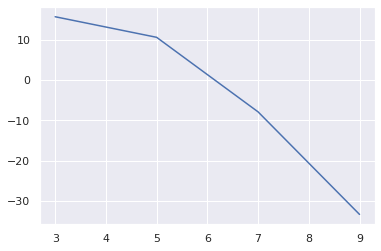

---Likelihoods---
Training: 32.499
Inlier: 30.286
Outlier: 19.428
========================= Training KD Tree =========================
/workspace/categorical-dsm/results/solar/seed_1/score_norms/last.ckpt-denoise-score_norms.npz
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 17.908216 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
---------------------------------------------------------------------------
17.908216 (6.293176) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
16.687965 (9.968559) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
11.538748 (12.152083) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
10.861592 (14.398118) with

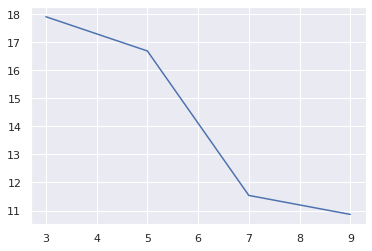

---Likelihoods---
Training: 38.679
Inlier: 32.597
Outlier: 26.672
========================= Training KD Tree =========================
/workspace/categorical-dsm/results/solar/seed_2/score_norms/last.ckpt-denoise-score_norms.npz
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 18.653548 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
---------------------------------------------------------------------------
18.653548 (1.421785) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
17.951059 (2.144577) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
-0.443128 (18.394412) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-59.403995 (72.517137) wit

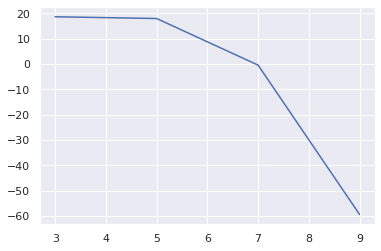

---Likelihoods---
Training: 39.071
Inlier: 28.235
Outlier: 21.213
========================= Training KD Tree =========================
/workspace/categorical-dsm/results/solar/seed_3/score_norms/last.ckpt-denoise-score_norms.npz
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 17.942842 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
---------------------------------------------------------------------------
17.942842 (3.730144) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
16.460196 (8.473525) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
8.324398 (4.362498) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-13.157937 (15.918706) with:

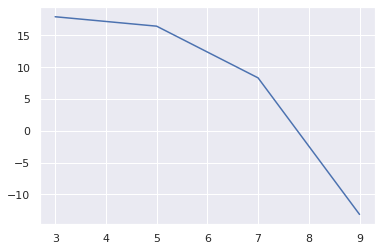

---Likelihoods---
Training: 35.437
Inlier: 35.965
Outlier: 20.895
========================= Training KD Tree =========================
/workspace/categorical-dsm/results/solar/seed_4/score_norms/last.ckpt-denoise-score_norms.npz
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 22.162688 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
---------------------------------------------------------------------------
22.162688 (3.310979) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
21.214240 (4.408577) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
10.161319 (12.784502) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-28.566666 (42.899967) wit

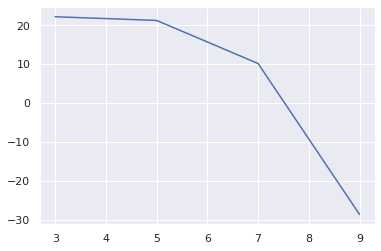

---Likelihoods---
Training: 35.269
Inlier: 34.755
Outlier: 25.683
========================= Training KD Tree =========================


In [84]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [85]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,63.344324,23.310534,28.431373,28.431373,62.578540,92.489335,82.480620,2.000000
std,5.405341,2.382082,5.414393,5.414393,5.775140,1.013324,2.254984,1.581139
min,55.016453,21.010032,20.588235,20.588235,53.538596,91.247178,79.742362,0.000000
25%,60.783530,21.249430,26.470588,26.470588,60.123921,92.003279,80.756954,1.000000
50%,66.018277,22.845417,29.411765,29.411765,65.379669,92.225480,82.535340,2.000000
75%,67.265959,24.920201,30.392157,30.392157,66.804844,93.115021,84.404925,3.000000
max,67.637401,26.527588,35.294118,35.294118,67.045671,93.855716,84.963520,4.000000


In [79]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"
kd_metrics

kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,61.741204,23.203374,29.411765,29.411765,60.901194,91.851712,81.315549,2.000000
std,8.608311,2.234856,3.100272,3.100272,9.155525,1.764326,3.599980,1.581139
min,51.938074,20.519836,25.490196,25.490196,50.609403,89.965840,77.621979,0.000000
25%,54.136308,21.010032,27.450980,27.450980,52.598497,90.291933,78.020976,1.000000
50%,62.311612,24.749202,29.411765,29.411765,61.630795,91.930085,81.076151,2.000000
75%,69.713789,24.749202,31.372549,31.372549,69.427774,92.908240,84.165527,3.000000
max,70.606235,24.988600,33.333333,33.333333,70.239500,94.162462,85.693114,4.000000


In [88]:
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
           count       mean       std        min        25%        50%   
model                                                                    
DAGMM        5.0  66.513908  3.585417  62.072503  63.588691  67.886457   
DSVDD        5.0  63.150935  5.976323  54.240766  61.764706  64.021888   
ECOD         5.0  86.600547  1.192220  85.259918  85.522116  86.764706   
IForest      5.0  84.516644  0.617881  83.686731  84.142727  84.689922   
MSMA-GMM     5.0  82.480620  2.254984  79.742362  80.756954  82.535340   
MSMA-KD      5.0  81.315549  3.599980  77.621979  78.020976  81.076151   

                                  ap                                  \
                75%        max count       mean       std        min   
model                                                                  
DAGMM     68.228454  70.793434   5.0  50.842517  5.192742  45.524398   
DSVDD     65.002280  70.725034   5.0  51.205410  3.940721  45.362767   
ECOD      87.448700  88.007296   5.0  72.234453  0.911863  70.829650   
IForest   84.769722  85.294118   5.0  67.985270  3.481350  63.198906   
MSMA-GMM  84.404925  84.963520   5.0  63.344324  5.405341  55.016453   
MSMA-KD   84.165527  85.693114   5.0  61.741204  8.608311  51.938074   

                                                      
                25%        50%        75%        max  
model                                                 
DAGMM     48.419716  50.185431  50.681995  59.401045  
DSVDD     50.734547  50.982924  52.691577  56.255235  
ECOD      72.114039  72.132222  73.007821  73.088533  
IForest   66.493979  67.753447  70.213955  72.266062  
MSMA-GMM  60.783530  66.018277  67.265959  67.637401  
MSMA-KD   54.136308  62.311612  69.713789  70.606235

In [89]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of solar: 43/145 = 0.30


In [91]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} $\pm$~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.30 & 67.99 $\pm$~3.48 & \B 72.23 $\pm$~0.91 & 50.84 $\pm$~5.19 & 51.21 $\pm$~3.94 & 63.34 $\pm$~5.41
roc_auc & 0.30 & 84.52 $\pm$~0.62 & \B 86.60 $\pm$~1.19 & 66.51 $\pm$~3.59 & 63.15 $\pm$~5.98 & 82.48 $\pm$~2.25


In [83]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

,model,metric,value
0,MSMA-GMM,ap,67.637401
1,MSMA-GMM,ap,60.783530
2,MSMA-GMM,ap,55.016453
3,MSMA-GMM,ap,67.265959
4,MSMA-GMM,ap,66.018277
...,...,...,...
205,DSVDD,roc_auc,65.002280
206,DSVDD,roc_auc,61.764706
207,DSVDD,roc_auc,70.725034
208,DSVDD,roc_auc,54.240766


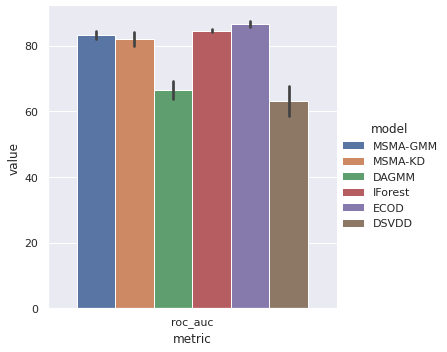

In [15]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

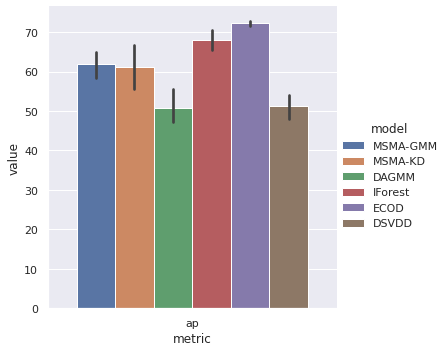

In [16]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")